# Light Curves Simulation for all SNe types

In [2]:
import snsim
import importlib
import matplotlib.pyplot as plt
import numpy as np

#secutiry check for numpy parallelization when using dask
def limit_numpy(nthreads=1):
    """ """
    import os
    threads = str(nthreads)
    print(f"threads {threads}")
    os.environ["NUMEXPR_NUM_THREADS"] = threads
    os.environ["OMP_NUM_THREADS"] = threads
    os.environ["OPENBLAS_NUM_THREADS"] = threads
    os.environ["MKL_NUM_THREADS"] = threads
    os.environ["VECLIB_MAXIMUM_THREADS"] = threads
limit_numpy(1)

import dask
import pandas as pd

threads 1


In [4]:
import sncosmo
model=sncosmo.Model('salt2')
_minwave = model.source.minwave()
_maxwave = model.source.maxwave()
print(_minwave,_maxwave)
lam_nodes = np.arange(_minwave, _maxwave + 800, 800)
lam_nodes

2000.0 9200.0


array([2000., 2800., 3600., 4400., 5200., 6000., 6800., 7600., 8400.,
       9200.])

In [5]:
band = sncosmo.get_bandpass('ztfi')
band.wave

array([6870., 6872., 6874., ..., 8956., 8958., 8960.])

In [8]:
model.source.name


'salt2'

### we use dask to speed up the simulation

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

/home/rosselli/.local/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40831 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40831/status,
Dashboard: http://127.0.0.1:40831/status,Workers: 4
Total threads: 8,Total memory: 15.32 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41931,Workers: 4
Dashboard: http://127.0.0.1:40831/status,Total threads: 8
Started: Just now,Total memory: 15.32 GiB
Comm: tcp://127.0.0.1:41589,Total threads: 2
Dashboard: http://127.0.0.1:39395/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:37907,


### init the survey

In [3]:
survey_conf = {
        'survey_file': './survey_file_example.csv',
        'sig_psf': 0.0,
        'sig_zp': 0.01,
        'zp': 25,
        'gain': 1,
        'ra_size': 7.295,
        'dec_size': 7.465,
        'noise_key': ['skynoise', 'skysigADU'], 
         }

### init the generator obejct for all SNe

In [4]:
snia_gen = {'M0': 'jla',
            'sigM': 0.1,
            'sct_model': 'G10',
             'force_n': 1000 ,
            'model_config': {'model_name': 'salt2',
                             'alpha': 0.14,
                             'beta': 2.9,
                             'dist_x1': 'N21',
                             'dist_c': [-0.055, 0.023, 0.150]}}

# for simplicity we use same configuration for SN core collapse
sncc_gen = {'M0': -19,
            'sigM': [1.5,1.5],
            'rate': 'ztf20',
            'model_config': {'model_name': 'vinc_nocorr',
                             }}

cosmology = {'name':'planck18'}



cmb = {'v_cmb': 0,
       'l_cmb':0,
       'b_cmb':0}

mw_dust = {'model': 'CCM89',}

#distribution of peculiar velocities of SNe
vpec_dist = {'mean_vpec':0,
             'sig_vpec':300}


## configuration dictionary, input of simulation

In [5]:
config_dic = {'data': {'write_path': './',
                       'sim_name': 'Test.simulation.allSN',
                       'write_format': 'parquet'},
              'survey_config': survey_conf,
              'sim_par': {'randseed': 1234, # Optional
                          'z_range': [0.01, 0.3]},
              'snia_gen': snia_gen,
              #'sniipl_gen': sncc_gen,
              #'sniin_gen': sncc_gen,
             # 'sniib_gen': sncc_gen,
             # 'snib_gen': sncc_gen,
              #'snic_gen': sncc_gen,
              #'snic-bl_gen': sncc_gen,
              'cosmology': cosmology,
              'mw_dust': mw_dust,
              'vpec_dist': vpec_dist,
              'cmb': cmb,
              'dask': {'use': True,
                       'nworkers': 4}#parameters to use dask, nworkers depends on your machine
             }

In [6]:
#config dask
cluster.scale(config_dic['dask']['nworkers'])

## Run the simulation

In [7]:
%%time
#initialize simulator object
#first time a bit long sncosmo has to download all the Templates
sim = snsim.Simulator(config_dic)

CPU times: user 474 ms, sys: 52.1 ms, total: 526 ms
Wall time: 491 ms


In [8]:
%%time
#run the simulation
sim.simulate()

      _______..__   __.         _______. __  .___  ___. 
     /       ||  \ |  |        /       ||  | |   \/   | 
    |   (----`|   \|  |       |   (----`|  | |  \  /  | 
     \   \    |  . `  |        \   \    |  | |  |\/|  | 
 .----)   |   |  |\   |    .----)   |   |  | |  |  |  | 
 |_______/    |__| \__|    |_______/    |__| |__|  |__| 
================================= Version : 0.4.5+dev ====== 
-----------------------------------------------------------

SIM NAME : Test.simulation.allSN
CONFIG FILE : No config file
SIM WRITE DIRECTORY : ./
SIMULATION RANDSEED : 1234

-----------------------------------------------------------

SURVEY FILE : ./survey_file_example.csv

First day in survey_file : 58000.00 MJD / 2017-09-04 00:00:00.000
Last day in survey_file : 58100.00 MJD / 2017-12-13 00:00:00.000

Survey effective duration is 100.00 days

Survey envelope area is 57.74 squared degrees (0.1 % of the sky)

No cut on survey file.

------------------------------------------------------

1000 SNIa lcs generated in 8.3 seconds
Sim file write in 0.0 seconds

-----------------------------------------------------------

OUTPUT FILE(S) : 
- ./Test.simulation.allSN_SNIa.parquet

CPU times: user 6.25 s, sys: 373 ms, total: 6.62 s
Wall time: 8.33 s


### After the simulations

In [9]:
#the sim object has the attribute samples, which contain the data of all the object we simulated
sim.samples
#one sim.sample object for each generator 

In [11]:
sim.samples[0].header
#header with useful parameter of each simulation

{'seed': 979371,
 'obj_type': 'SNIa',
 'rate': 'lambda z: 3e-5',
 'model_name': ['salt2'],
 'mw_dust': {'model': 'CCM89', 'rv': 3.1},
 'mod_fcov': False,
 'M0': -19.123830232811475,
 'sigM': 0.1,
 'alpha': 0.14,
 'beta': 2.9,
 'm_vp': 0,
 's_vp': 300,
 'M0_band': 'bessell_b',
 'dist_x1': 'N21',
 'mean_c': -0.055,
 'dist_c': 'asym_gauss',
 'sig_c_low': 0.023,
 'sig_c_hi': 0.15,
 'sct_mod': 'G10',
 'G10_L0': 2157.3,
 'G10_F0': 0.0,
 'G10_F1': 0.000108,
 'G10_dL': 800.0,
 'cosmo': {'cosmod_name': 'planck18'}}

In [11]:
#meta attribute return the parameters of each object, same as sim_lcs.attrs
sim.samples[0].meta[0]

{'zobs': 0.08514039365428472,
 'G10_RndS': 353574,
 'mw_r_v': 3.1,
 'mw_ebv': 0.0894629005790134,
 'sim_t0': 58008.88437023253,
 'sim_x1': 0.39903049707041854,
 'sim_c': 0.08494218973928579,
 'sim_x0': 0.0004463834760406595,
 'type': 'snIa',
 'ID': 0,
 'ra': 0.7828707370610833,
 'dec': 0.6664040790647171,
 'zcos': 0.08439615731630058,
 'zCMB': 0.08514039365428472,
 'zpec': 0.0006863140679381759,
 'vpec': 205.75178138716473,
 'z2cmb': 0.0,
 'sim_mu': 37.99912258538066,
 'como_dist': 366.4718552501182,
 'sim_mb': 18.8770954270438,
 'mag_sct': -0.188665006179458,
 'template': 'salt2'}

In [23]:
#return the simulated lightcurves
sim.samples[1].sim_lcs

time  fluxtrue         flux     fluxerr        mag  \
ID  epochs                                                               
0   0       58000.000000  5.544801  -495.709935  629.559099        NaN   
    1       58002.040816  5.061043   329.785896  794.921332  18.704420   
    2       58004.081633  4.669393  -274.616237  857.810756        NaN   
    3       58006.122449  4.359750   158.501341  736.173233  19.499918   
    4       58008.163265  4.111641  1760.295120  716.205019  16.886036   
...                  ...       ...          ...         ...        ...   
224 29      58091.836735  0.000000   124.919797  882.049012  19.758422   
    30      58093.877551  0.000000  1232.953559  998.985068  17.272633   
    31      58095.918367  0.000000   372.227737  210.301351  18.572978   
    32      58097.959184  0.000000    71.697165  903.796792  20.361245   
    33      58100.000000  0.000000  -122.251439  535.020328        NaN   

               magerr  zp zpsys  gain    skynoise  band  fieldID  sig_zp  \
ID  epochs                                                                 
0   0             NaN  25    ab     1  629.554693  ztfg        1    0.01   
    1        2.617076  25    ab     1  794.918147  ztfg        1    0.01   
    2             NaN  25    ab     1  857.808033  ztfg        1    0.01   
    3        5.042796  25    ab     1  736.170271  ztfg        1    0.01   
    4        0.441750  25    ab     1  716.202148  ztfg        1    0.01   
...               ...  ..   ...   ...         ...   ...      ...     ...   
224 29       7.666299  25    ab     1  882.049012  ztfr        1    0.01   
    30       0.879704  25    ab     1  998.985068  ztfg        1    0.01   
    31       0.613420  25    ab     1  210.301351  ztfg        1    0.01   
    32      13.686523  25    ab     1  903.796792  ztfg        1    0.01   
    33            NaN  25    ab     1  535.020328  ztfg        1    0.01   

            sig_psf  
ID  epochs           
0   0           0.0  
    1           0.0  
    2           0.0  
    3           0.0  
    4           0.0  
...             ...  
224 29          0.0  
    30          0.0  
    31          0.0  
    32          0.0  
    33          0.0  

[10996 rows x 14 columns]

In [9]:
def sine_interp(x_new, fun_x, fun_y):
    """Return the sinus interpolation of a function at x.

    Parameters
    ----------
    x_new : float
        New x where evaluate the function.
    fun_x : list(float)
        Existing function x.
    fun_y : list(float)
        Existing function y.

    Returns
    -------
    float
        The sinus interpolation value of f at x_new.

    """
    if len(fun_x) != len(fun_y):
        raise ValueError('x and y must have the same len')

    if (x_new > fun_x[-1]) or (x_new < fun_x[0]):
        raise ValueError('x_new is out of range of fun_x')

    inf_sel = x_new >= fun_x[:-1]
    sup_sel = x_new < fun_x[1:]
    if inf_sel.all():
        idx_inf = -2
    elif sup_sel.all():
        idx_inf = 0
    else:
        idx_inf = np.where(inf_sel * sup_sel)[0][0]

    x_inf = fun_x[idx_inf]
    x_sup = fun_x[idx_inf + 1]
    Value_inf = fun_y[idx_inf]
    Value_sup = fun_y[idx_inf + 1]
    sin_interp = np.sin(np.pi * (x_new - 0.5 * (x_inf + x_sup)) / (x_sup - x_inf))

    return 0.5 * (Value_sup + Value_inf) + 0.5 * (Value_sup - Value_inf) * sin_interp


def scattering_law(_parameters,_minwave,_colordisp,_maxwave):
    L0, F0, F1, dL = _parameters[:-1]
    lam = _minwave
    sigma_lam = []
    sigma_val = []

    while lam < _maxwave:
        sigma_lam.append(lam)
        val = _colordisp(lam)
        if lam > L0:
            val *= 1 + (lam - L0) * F1
        elif lam < L0:
            val *= 1 + (lam - L0) * F0

        sigma_val.append(val)
        lam += dL
    return np.asarray(sigma_lam), np.asarray(sigma_val)

   
      

        
def lam_scatter(_parameters,_minwave,_colordisp,_maxwave):
    sigma_lam, sigma_val = scattering_law(_parameters,_minwave,_colordisp,_maxwave)
    RS = _parameters[-1]
    return sigma_lam, sigma_val# * np.random.default_rng(int(RS)).normal(0, 1, size=len(sigma_val))



def propagate(_parameters,_minwave,_colordisp,_maxwave, wave):
        
        lam, scatter = lam_scatter(_parameters,_minwave,_colordisp,_maxwave)
        print(lam)
        scattering = np.asarray([sine_interp(w, lam, scatter) for w in wave])
        return scattering,10**(-0.4 * scattering)


In [10]:
import sncosmo
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2',
                      effects=[dust],
                      effect_names= ['mw_'],
                      effect_frames= ['obs'])

fixpar = {'z': sim.samples[0].meta[0]['zobs'],
         'mw_ebv':  sim.samples[0].meta[0]['mw_ebv'],
            't0':  sim.samples[0].meta[0]['sim_t0'],
            'c':  sim.samples[0].meta[0]['sim_c'],
            'x1': sim.samples[0].meta[0]['sim_x1'],
            'x0': sim.samples[0].meta[0]['sim_x0']}
        
model.set(**fixpar)


_param_names = ['L0', 'F0', 'F1', 'dL', 'RndS']
param_names_latex = [r'\lambda_0', 'F_0', 'F_1', 'd_L', 'RS']

    
        
_parameters = np.array([2157.3, 0.0, 1.08e-4, 800,
                          sim.samples[0].meta[4]['G10_RndS']])

_minwave = model.source.minwave()

_maxwave = model.source.maxwave()
print(_minwave,_maxwave)
_colordisp = model.source._colordisp
wave=np.linspace(_minwave,_maxwave,800)
#wave=np.linspace(2800,8000,1000)     
sct,st=propagate(_parameters,_minwave,_colordisp,_maxwave, wave)
len(sct)

NameError: name 'sim' is not defined

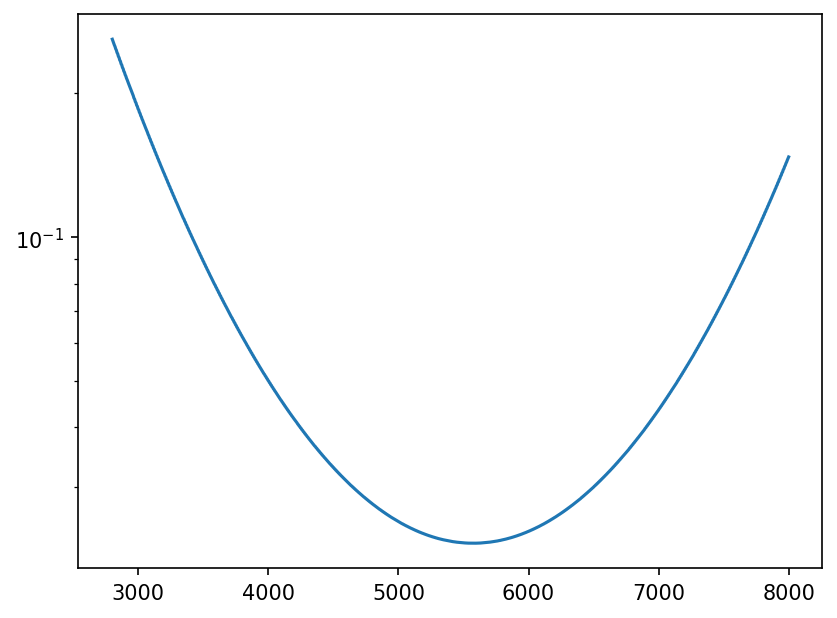

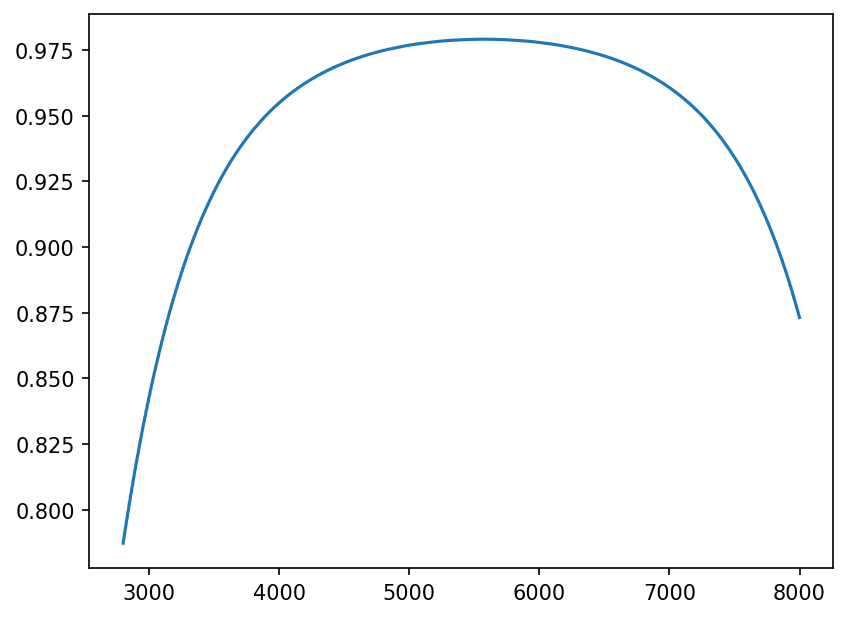

In [39]:
plt.figure(dpi=150)
plt.plot(wave,sct)
plt.yscale('log')

plt.figure(dpi=150)
plt.plot(wave,st)
